In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from pathlib import Path
from scipy import signal
from scipy.ndimage import maximum_filter1d, minimum_filter1d

matplotlib.rcParams['figure.figsize'] = [32, 8]

In [2]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [13]:
trace = np.fromfile('C:/Users/reichler/data/2021_08_09/m400061/led.yuv', np.uint8)
trace_yuv = np.fromfile('C:/Users/reichler/data/2021_08_09/m400061/led_fromyuv.yuv', np.uint8)

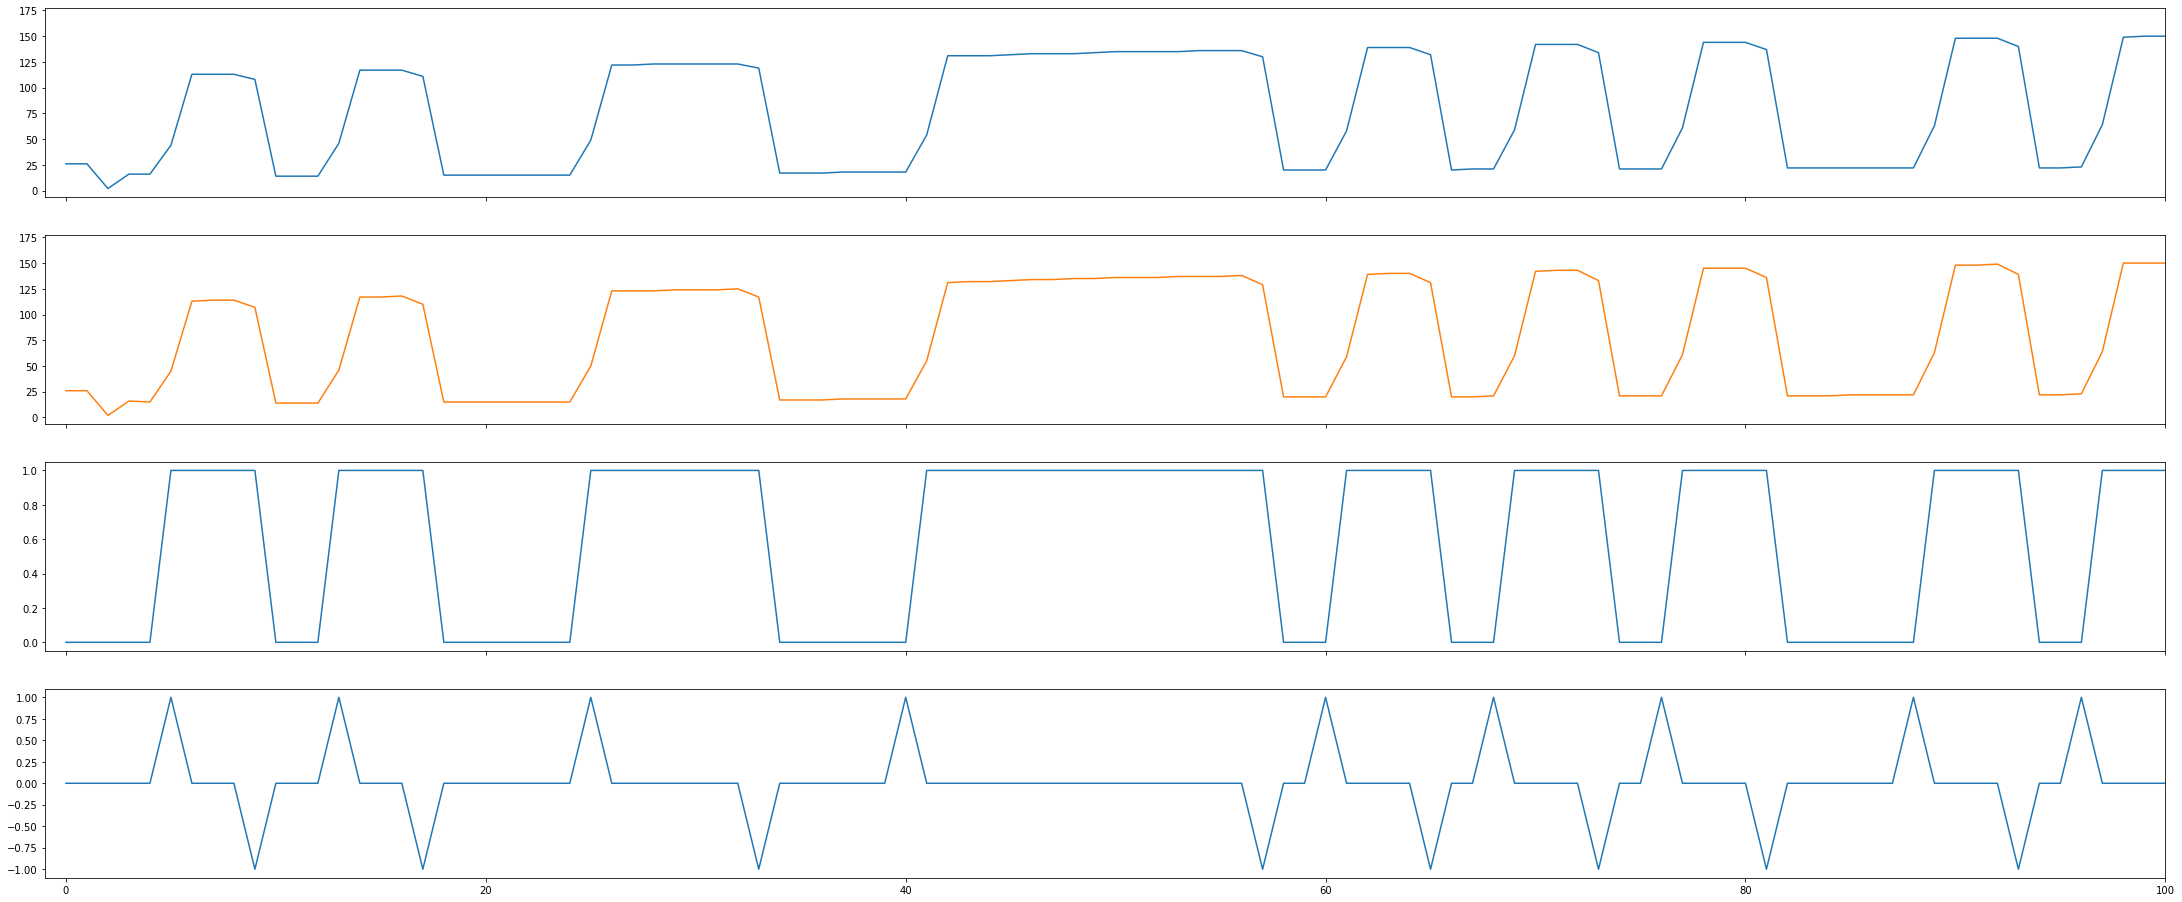

In [20]:
fig, ax = plt.subplots(4, figsize=(38,16), sharex=True)
ax[0].plot(trace)
ax[1].plot(trace_yuv, c='C1')
ax[2].plot(trace>42)
ax[3].plot(np.diff((trace>50).astype(float)))
ax[3].set_xlim(-1, 100);

NameError: name 'DATA_DT' is not defined

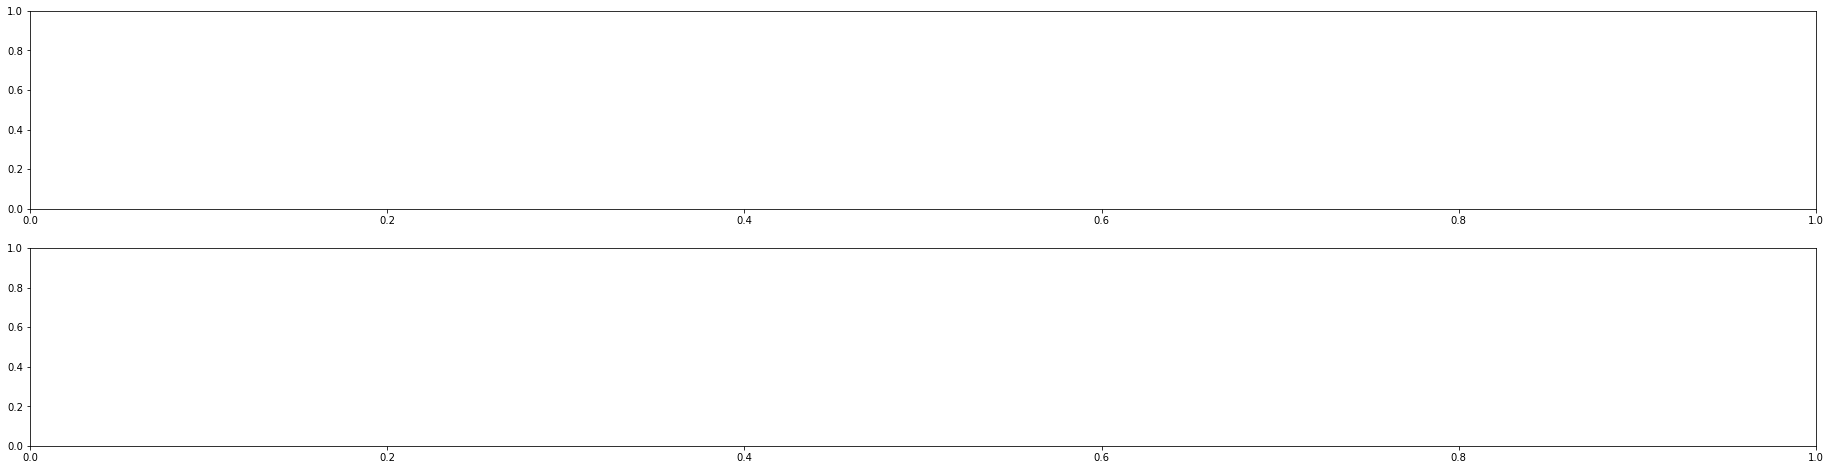

In [18]:
fig, ax = plt.subplots(2, figsize=(32, 8))
aux1 = np.memmap('100_ADC1_0.continuous', dtype=DATA_DT, offset=1024)['samples'].flatten()
aux2 = np.memmap('100_ADC2_0.continuous', dtype=DATA_DT, offset=1024)['samples'].flatten()
ax[0].plot(aux1[50000:100000])
ax[1].plot(aux2[50000:100000])

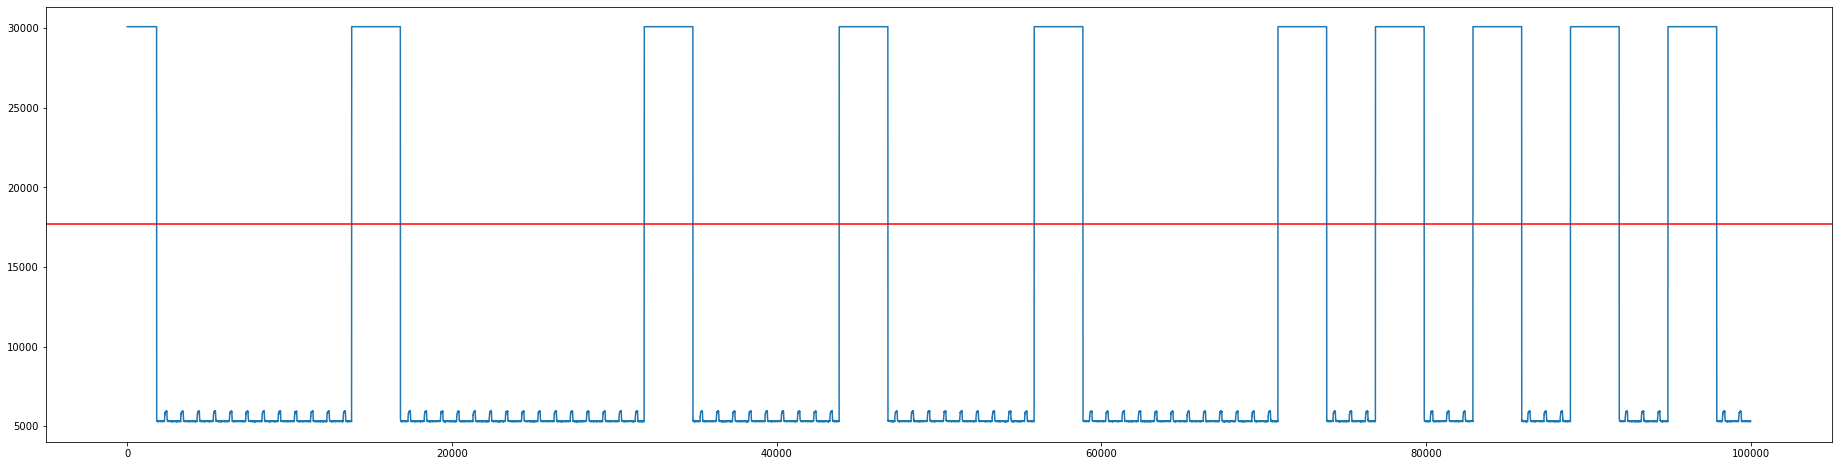

In [50]:
data = aux1[:100000]
threshold = (np.max(data)-np.min(data))/2+np.min(data)
plt.plot(data)
plt.axhline(threshold, c='r')

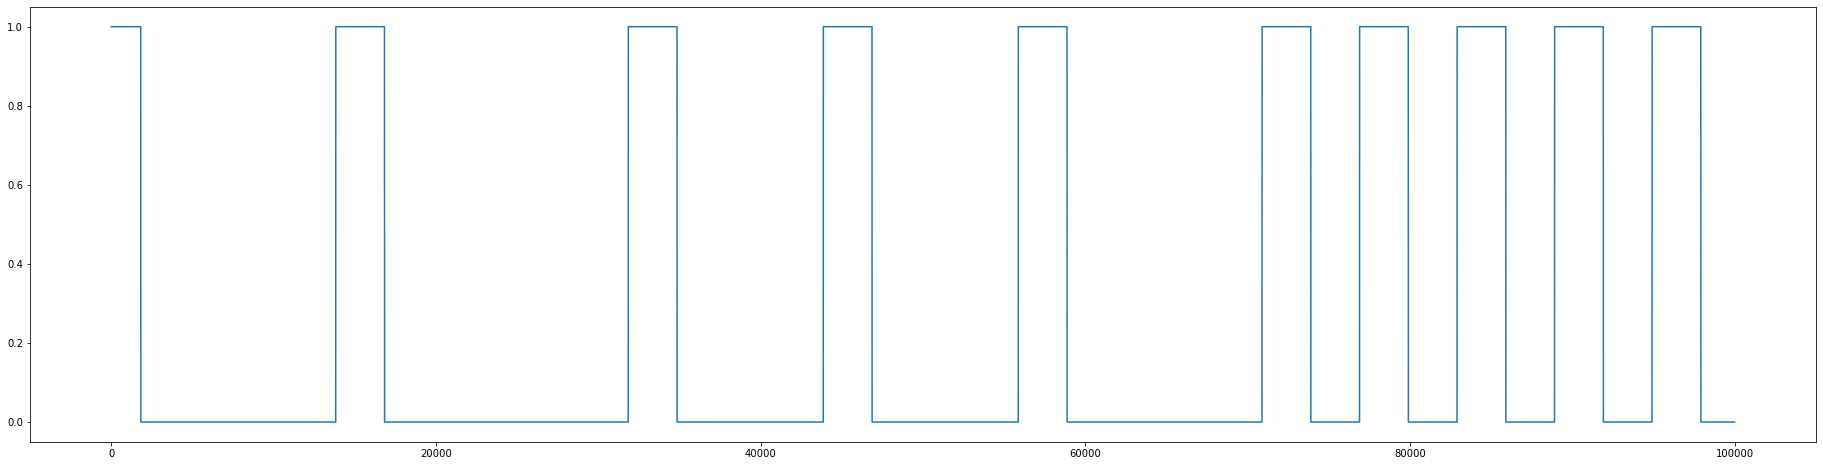

In [68]:
thr = (data > threshold).astype(float)
plt.plot(thr)

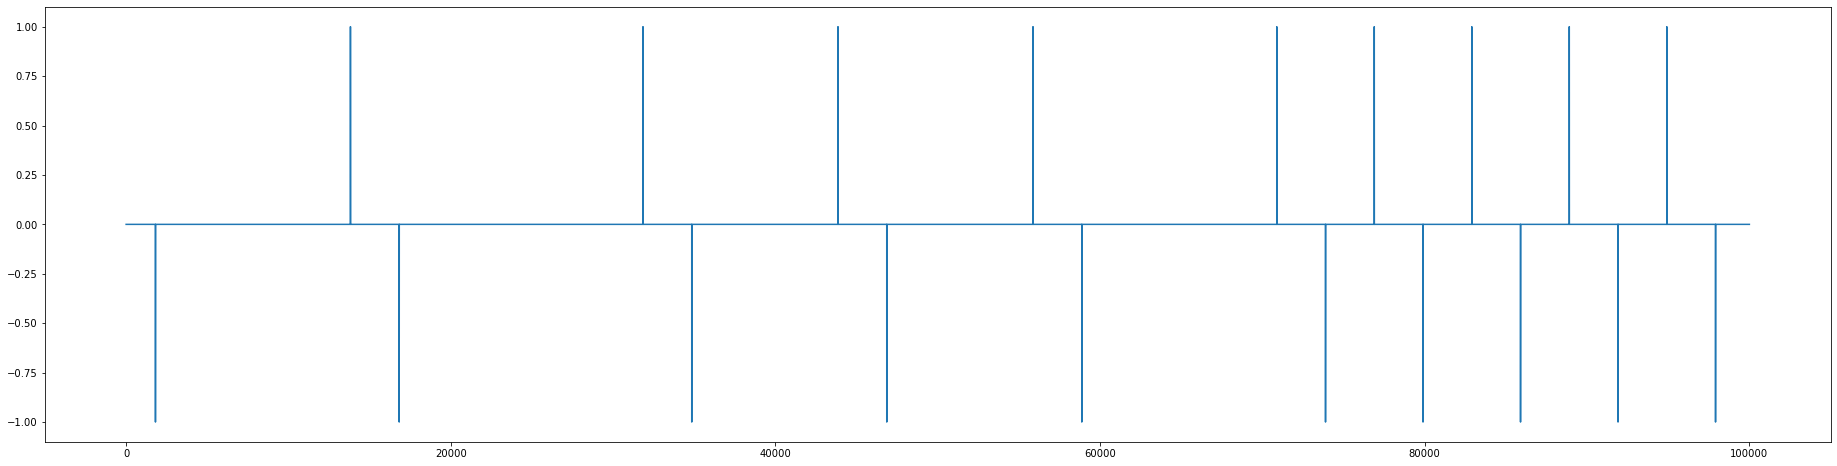

In [79]:
edges = np.diff(thr)
plt.plot(edges)

starts = np.nonzero(edges > 0)[0]
ends = np.nonzero(edges < 0)[0]

In [80]:
starts.shape, ends.shape

((9,), (10,))

In [93]:
np.mean(np.diff(np.array(list(zip(starts, ends[np.min(np.nonzero(ends > starts[0])[0]):]))), axis=1))

3003.4444444444443

In [88]:
list(zip([1, 2, 3], ['a', 'b', 'c']))

[(1, 'a'), (2, 'b'), (3, 'c')]

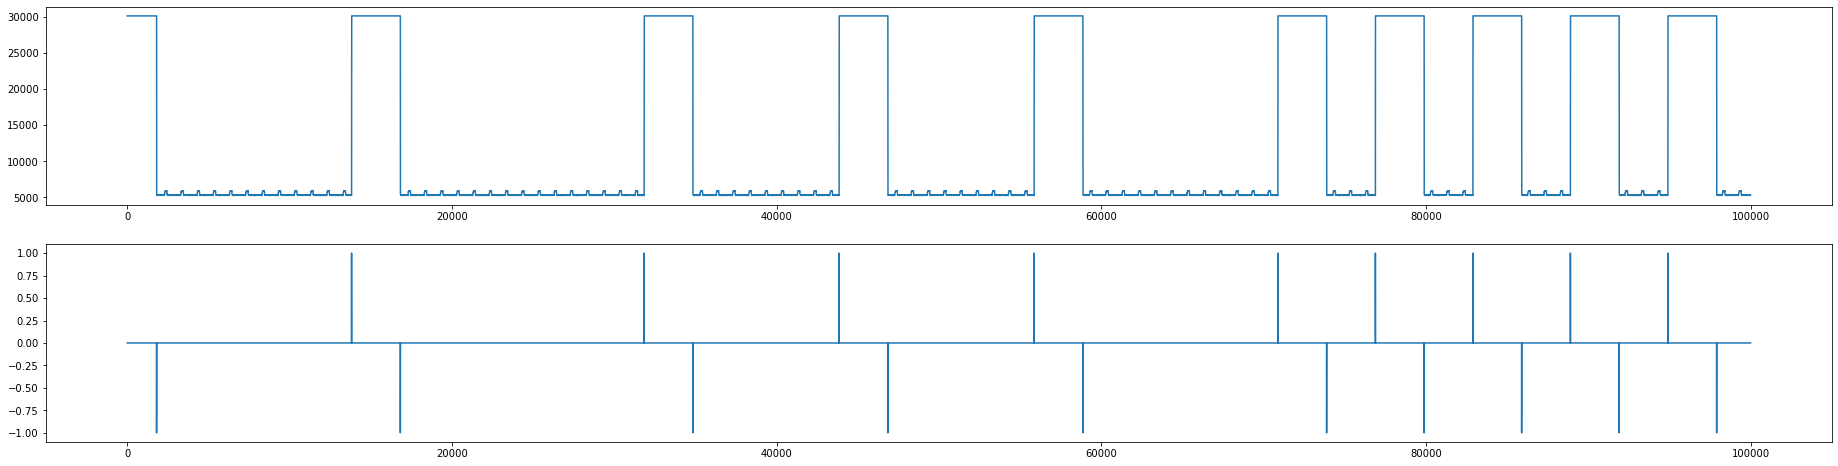

In [13]:
fig, ax = plt.subplots(2)
ax[0].plot(aux1[:100000])
peaks = np.diff((aux1>20000).astype(float))
ax[1].plot(peaks[:100000])
deltas = np.diff(np.nonzero(peaks>0))/30

In [14]:
delta_n = deltas/200
cond_dist = np.zeros((10,30))
for i in range(10):
    delta1 = deltas[np.logical_and(delta_n<i*1.5,delta_n>(i-1)*1.5)]
    delta_1_hist = np.histogram(delta1,bins = 30,range = (0,2000))
    delta_t = delta_1_hist[1]
    cond_dist[i,:] = delta_1_hist[0]

[   0.           66.66666667  133.33333333  200.          266.66666667
  333.33333333  400.          466.66666667  533.33333333  600.
  666.66666667  733.33333333  800.          866.66666667  933.33333333
 1000.         1066.66666667 1133.33333333 1200.         1266.66666667
 1333.33333333 1400.         1466.66666667 1533.33333333 1600.
 1666.66666667 1733.33333333 1800.         1866.66666667 1933.33333333
 2000.        ]


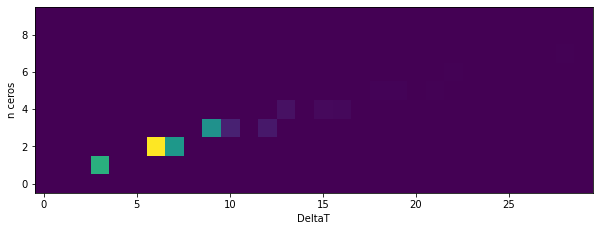

In [15]:
fig, ax = plt.subplots(1, figsize = (10,15))
ax.imshow(cond_dist,origin = 'lower')
ax.set_xlabel('DeltaT')
ax.set_ylabel('n ceros')
print(delta_t)

In [11]:
d = {}
for n in range(128, 256):
    seq = f'{n:08b}g'
    p = seq.find('10')
    num_0_seq = seq.count('10')
#     print(f'Sequence: {seq} with {num_0_seq} subsections')
    for zsq in range(num_0_seq):
        count = 0
        for c in seq[p+1:]:
            if c == '0':
                count+=1
            else if c == 'g':
                if str(count) in d:
                    d[str(count)] += 1
                else:
                    d[str(count)] = 1
            else:
                p += count+1
                break

SyntaxError: invalid syntax (<ipython-input-11-caa560c3de8c>, line 12)

Text(0, 0.5, 'n ceros')

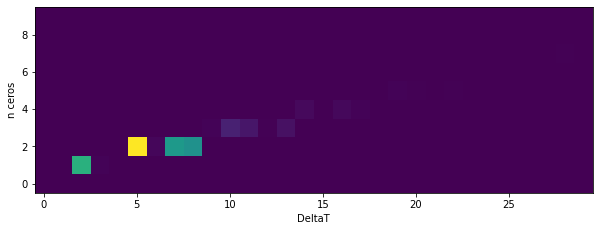

In [141]:
P(S|t) = P(S) * P(t|S)/ P(t)

(0.0, 2000.0)

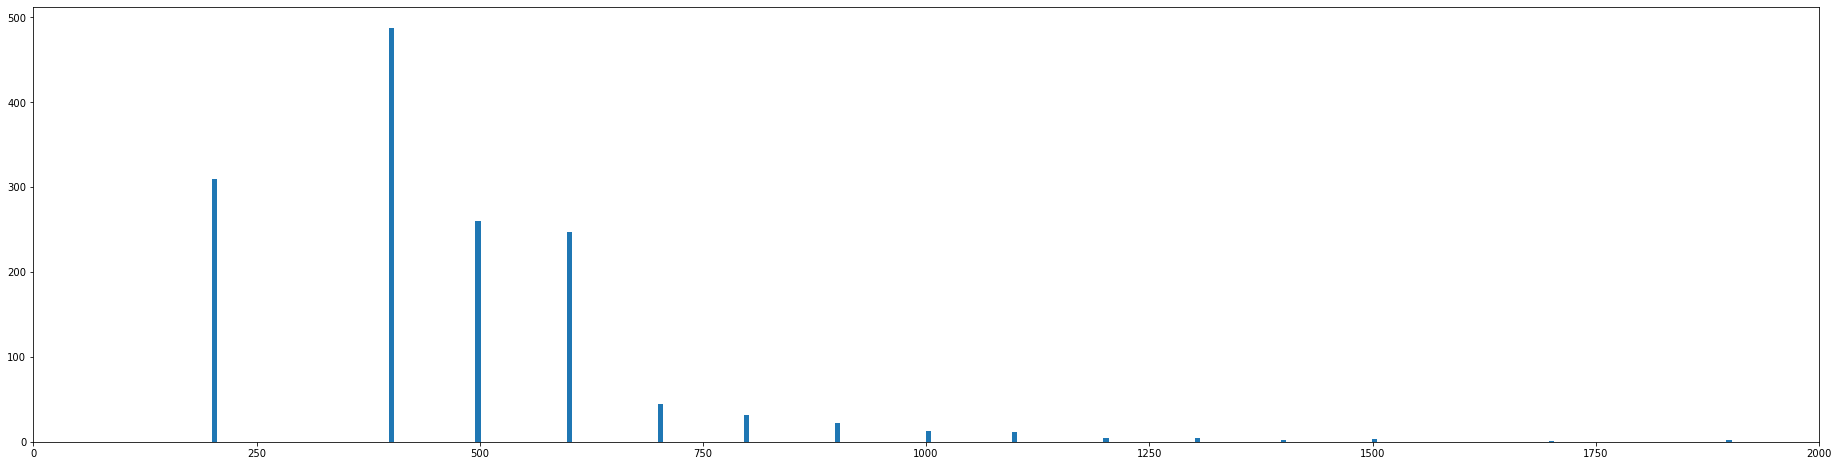

In [16]:
plt.hist(deltas.flatten(), bins=300);
plt.xlim(0, 2000)

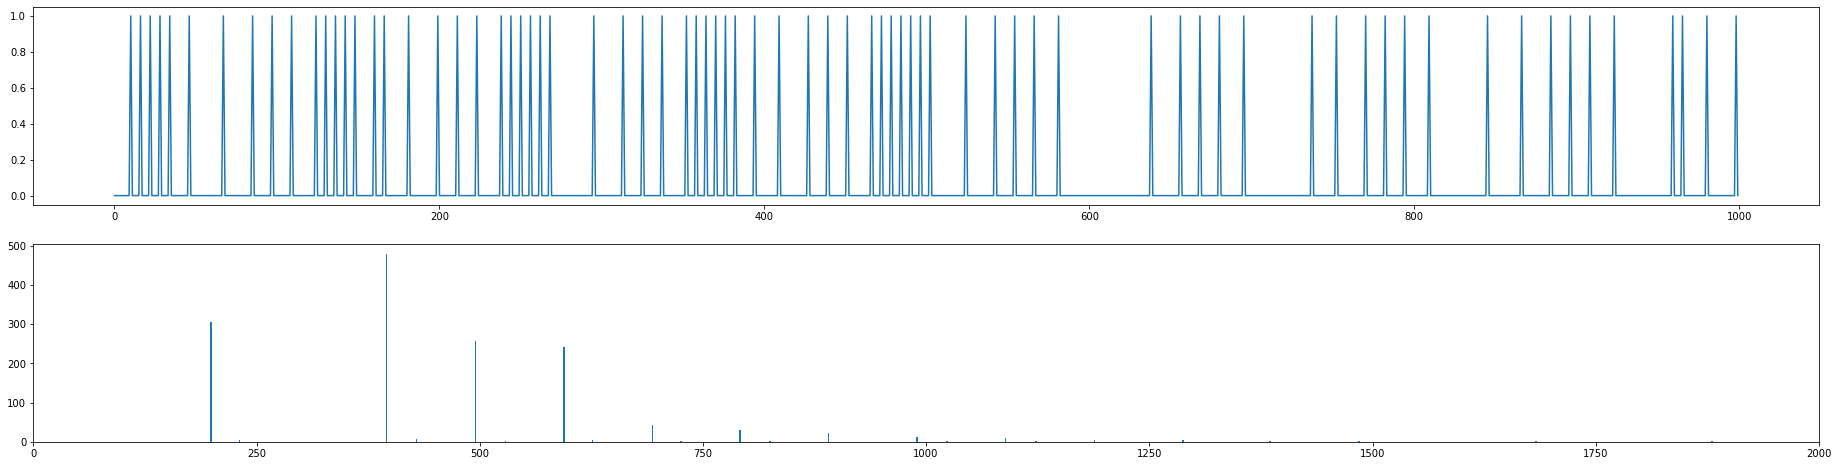

In [123]:
fig, ax = plt.subplots(2)
peaks = np.diff((led_yuv>150).astype(float).flatten()) > 0
ax[0].plot(peaks[:1000])
deltas = np.diff(np.nonzero(peaks>0)).astype('float')*33
ax[1].hist(deltas.flatten(), bins=1000)
ax[1].set_xlim(0, 2000);
# ax[1].set_ylim(0, 10)

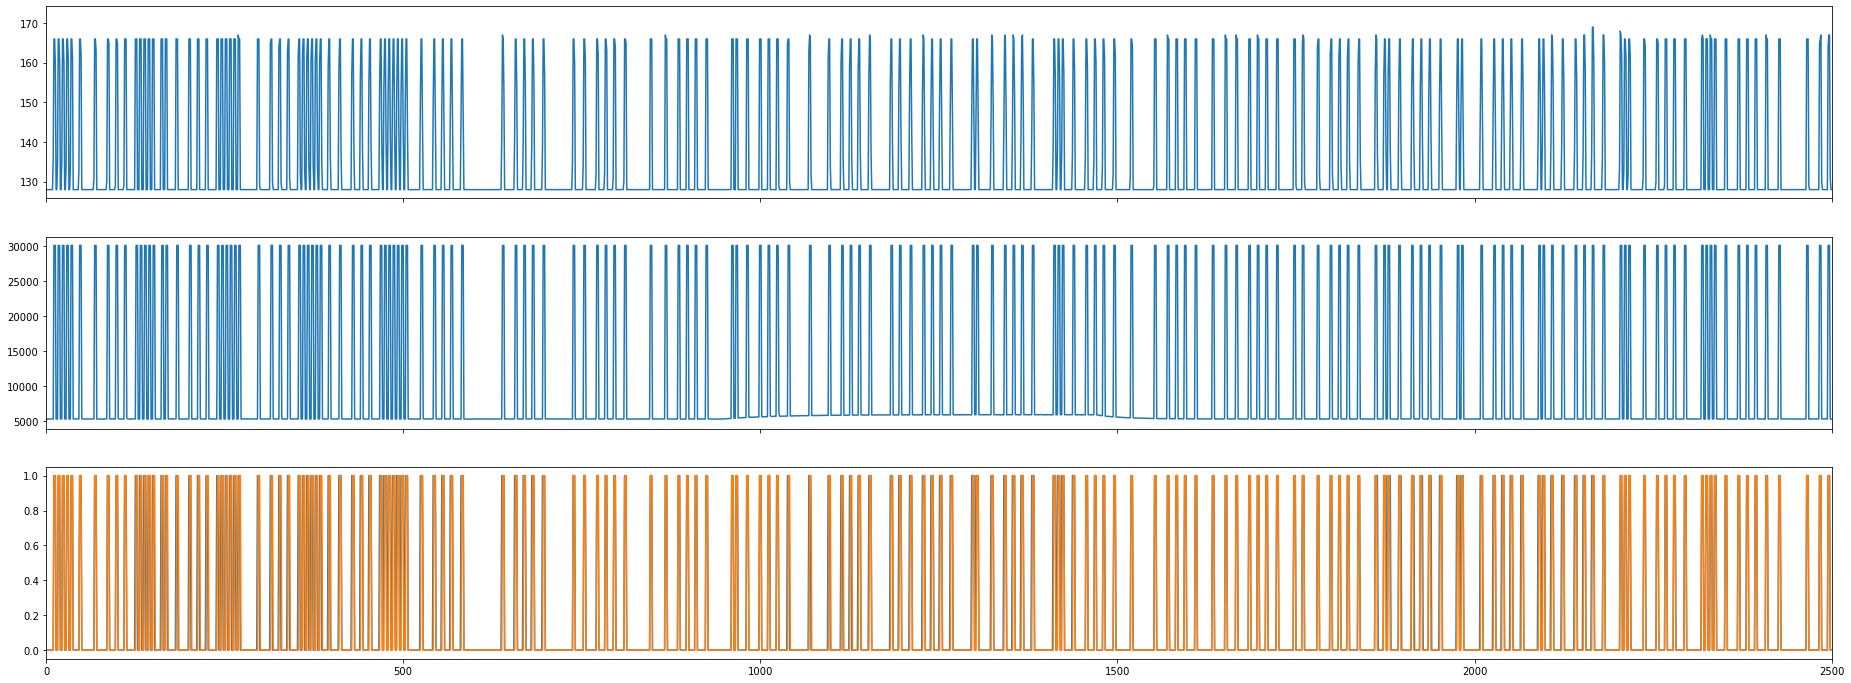

In [17]:
aux1ds = aux1[::1000]
fig, ax = plt.subplots(3, figsize=(32, 12), sharex=True)
ofs = 0
ax[0].plot(led_yuv[ofs:])
ax[1].plot(aux1ds[ofs+60:])
ax[1].set_xlim(0, 2500)
ax[2].plot(normalize(led_yuv[ofs:])>.2)
ax[2].plot(normalize(aux1ds[ofs+60:].reshape(-1, 1))>.2)

In [18]:
norm_led = normalize(led_yuv).flatten()
norm_aux = normalize(aux1ds.reshape(-1, 1)).flatten()
print(norm_led.shape, norm_aux.shape, norm_aux.dtype)

(19877,) (19873,) float64


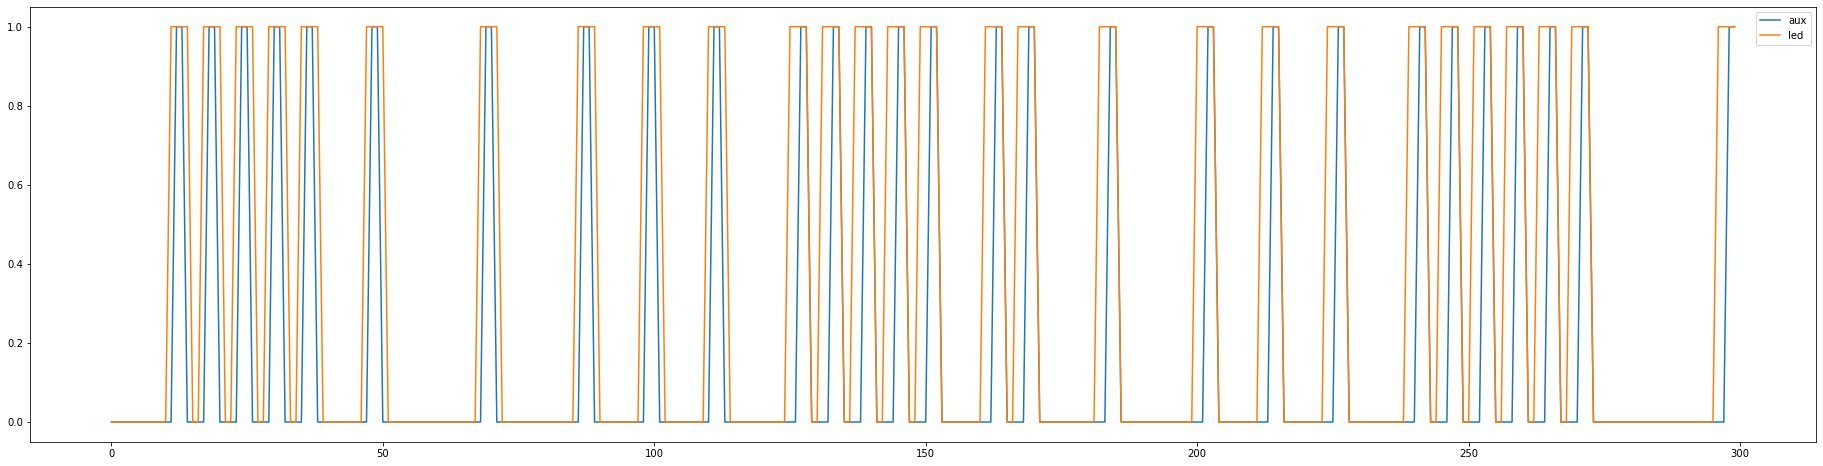

In [41]:
norm_led_thr = (normalize(led_yuv).flatten()>.01).astype(np.double)
norm_aux_thr = (normalize(aux1ds.reshape(-1, 1)).flatten()>.09).astype(np.double)

norm_led_max = maximum_filter1d((norm_led>0.2).astype(np.double), size=2, cval=0, mode='constant')
norm_aux_min = minimum_filter1d((norm_aux>0.2).astype(np.double), size=2, cval=0, mode='constant')

offset = 60
start = 0
nframes = 300
plt.plot(norm_aux_min[start+offset:start+nframes+offset], label='aux')
plt.plot(norm_led_max[start:start+nframes], label='led')
plt.legend()

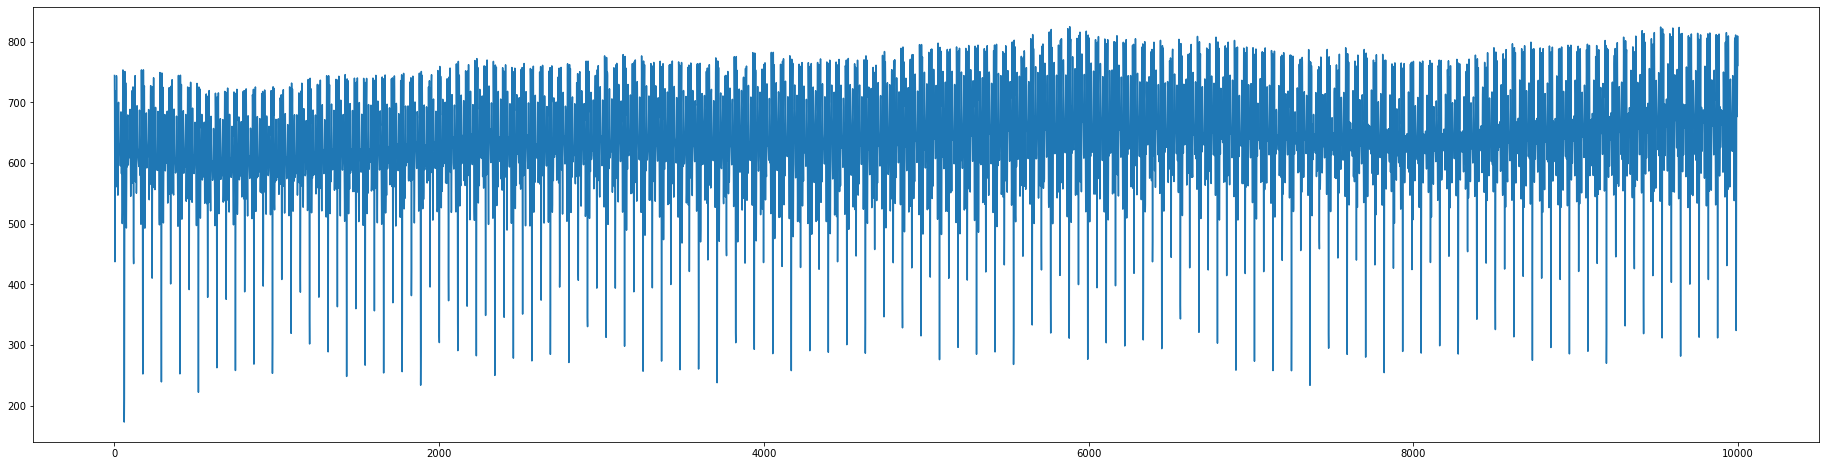

In [35]:
p = []
residuals = []
ws = 2000
nsteps = 10000
woi = norm_led[:ws]
for n in range(nsteps):
    res = np.abs(norm_aux[n:n+ws]-woi)
    cost = np.sum(res)
    p.append(cost)
    residuals.append(res)
plt.plot(p)

Found minimum at offset 60


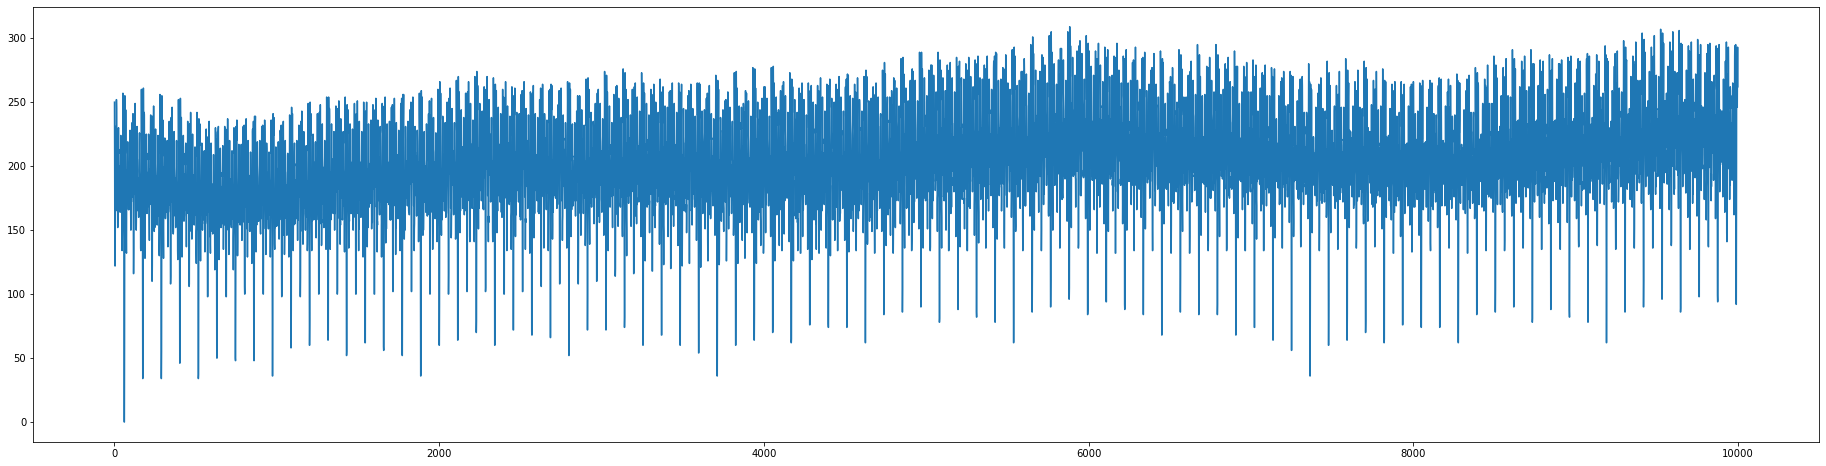

In [36]:
p = []
residuals = []
ws = 2000
nsteps = 10000
woi = norm_led_max[:ws]
for n in range(nsteps):
    res = (norm_aux_min[n:n+ws]-woi)
    cost = np.sum(res>0)
    p.append(cost)
    res[res<0]=0
    residuals.append(res)
plt.plot(p)
print(f'Found minimum at offset {np.argmin(p)}')

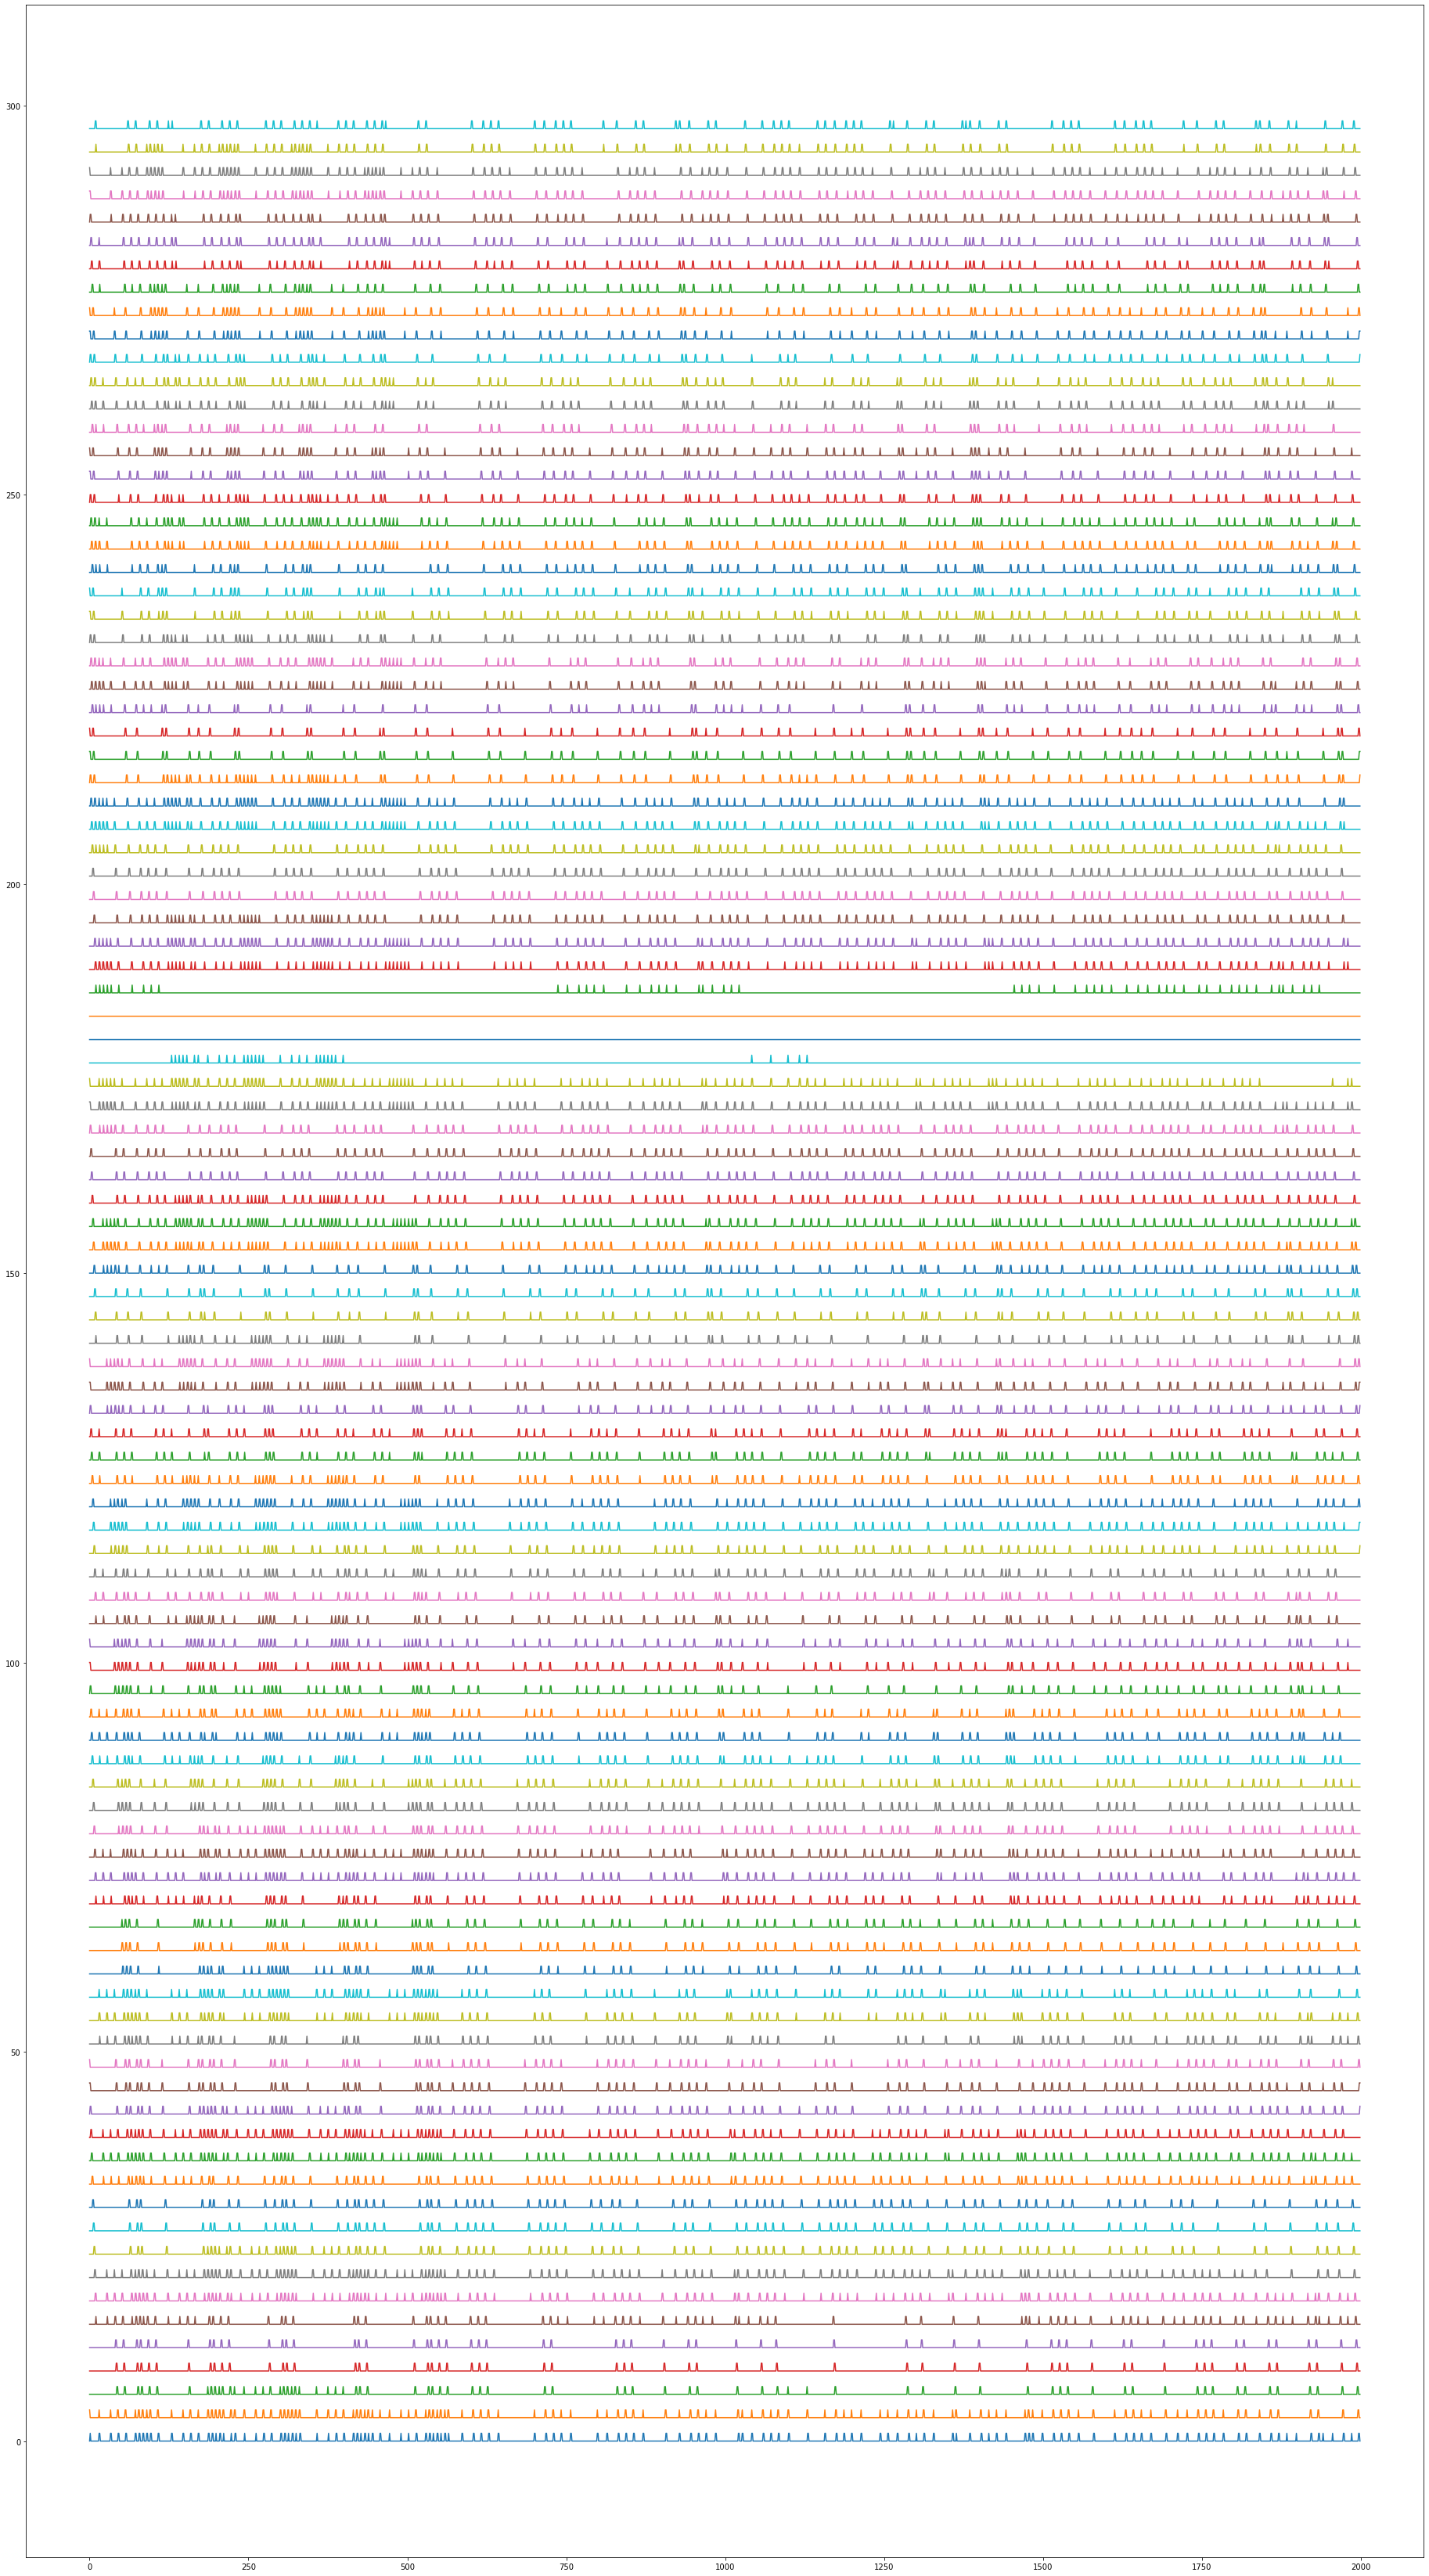

In [94]:
fig, ax = plt.subplots(1, figsize=(32, 60))
for n in range(100):
    ax.plot(residuals[n]+n*3)

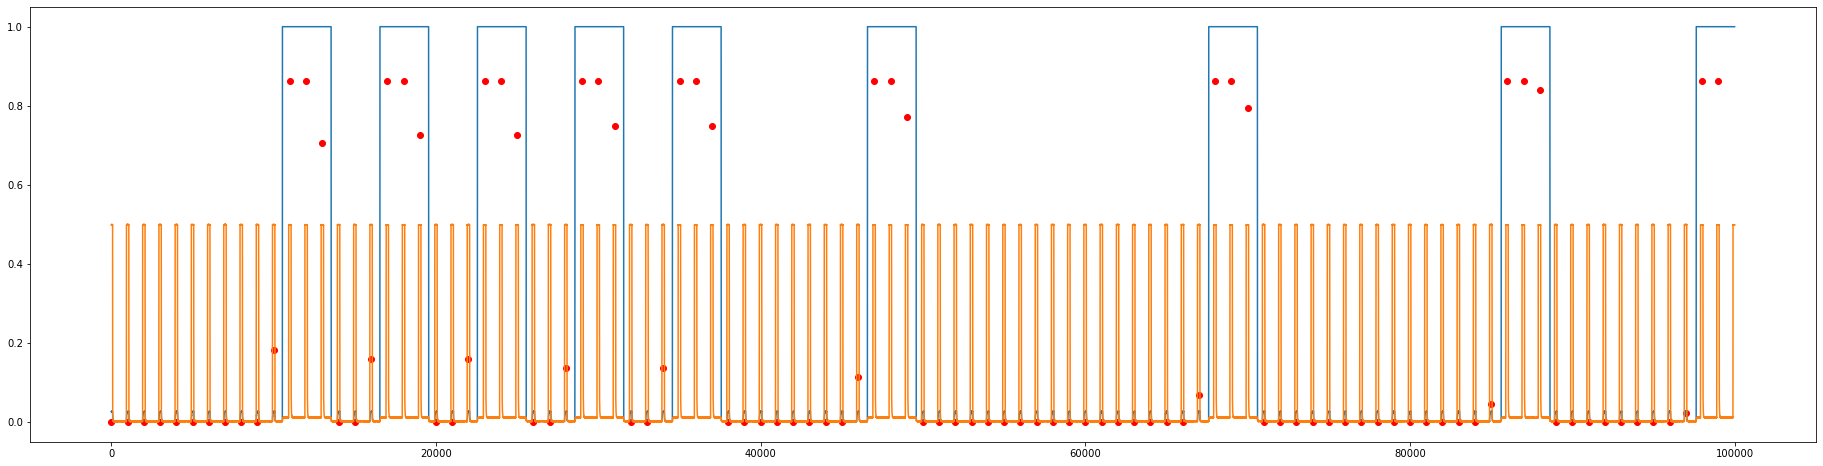

In [26]:
nframes = 100
start = 60350
plt.plot(normalize(aux1[start:start+nframes*1000]))
plt.scatter(np.linspace(0, nframes-1, nframes)*1000, norm_led[:nframes], c='r')
plt.plot(normalize(aux2[start:start+nframes*1000])*0.5)
# plt.axvline(1000, color='k')

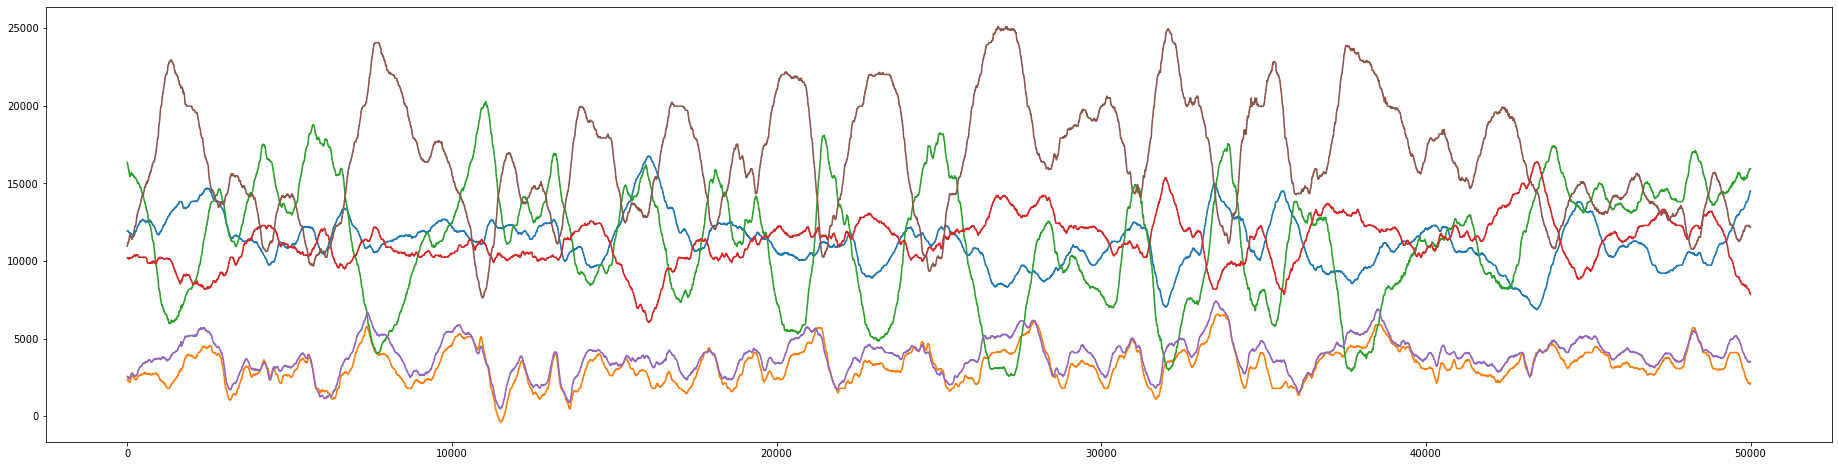

In [410]:
for n in range(6):
    adxx = np.memmap(f'100_AUX{n+1}_0.continuous', dtype=DATA_DT, offset=1024)['samples'].flatten()
    plt.plot(adxx[:50000])